In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="deep", font_scale=1.1)


In [9]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
y = train["SalePrice"]
X = train.drop("SalePrice", axis=1)

X.shape, y.shape

((1460, 80), (1460,))

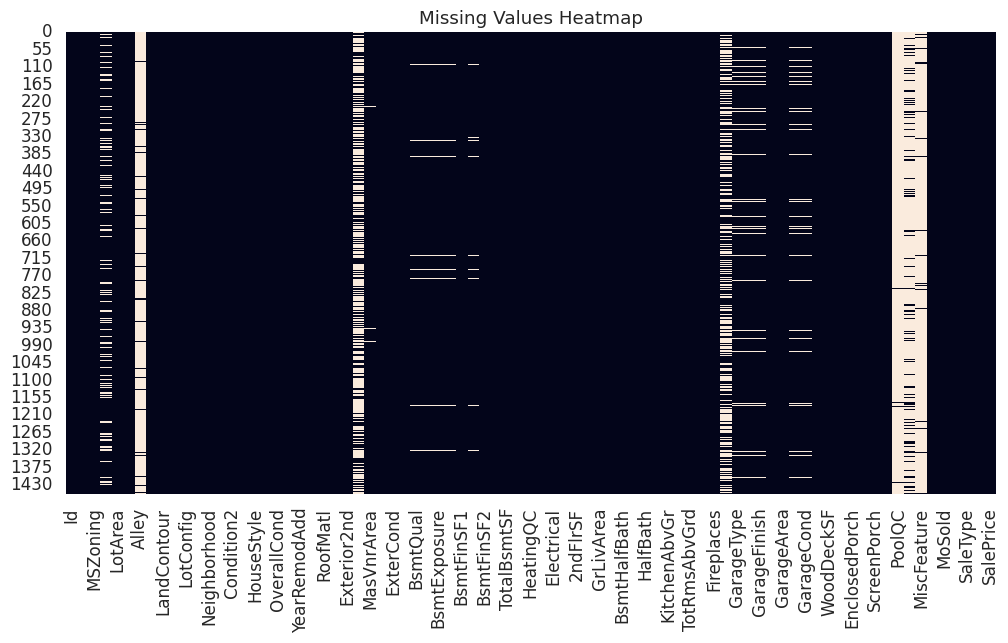

In [12]:
#missing_values_
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

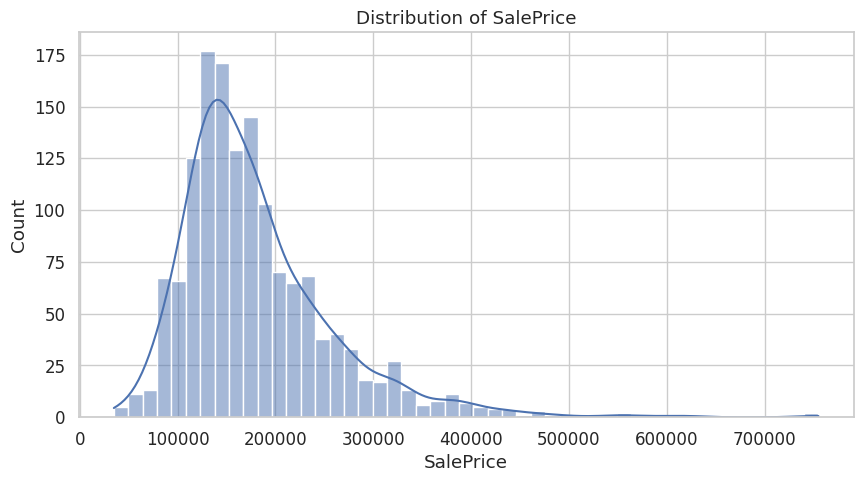

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(train["SalePrice"], kde=True)
plt.title("Distribution of SalePrice")
plt.show()

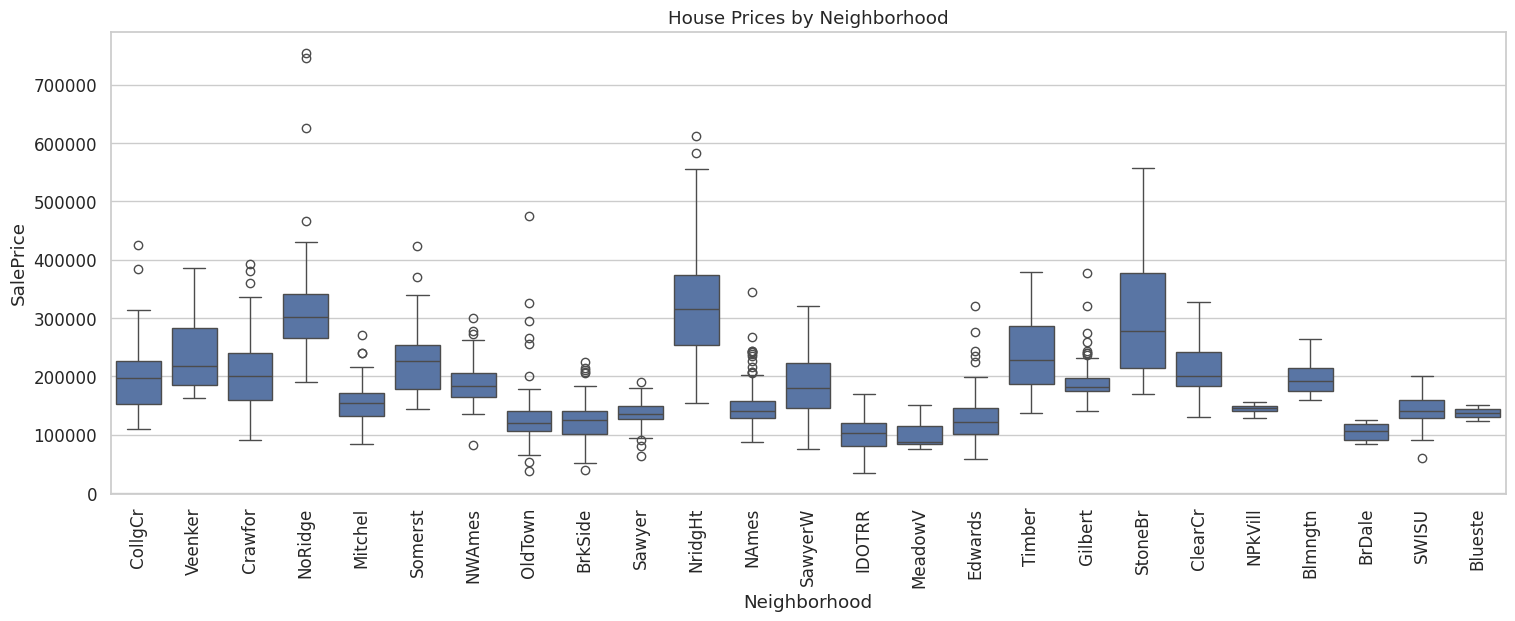

In [14]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=train, x="Neighborhood", y="SalePrice")
plt.xticks(rotation=90)
plt.title("House Prices by Neighborhood")
plt.show()


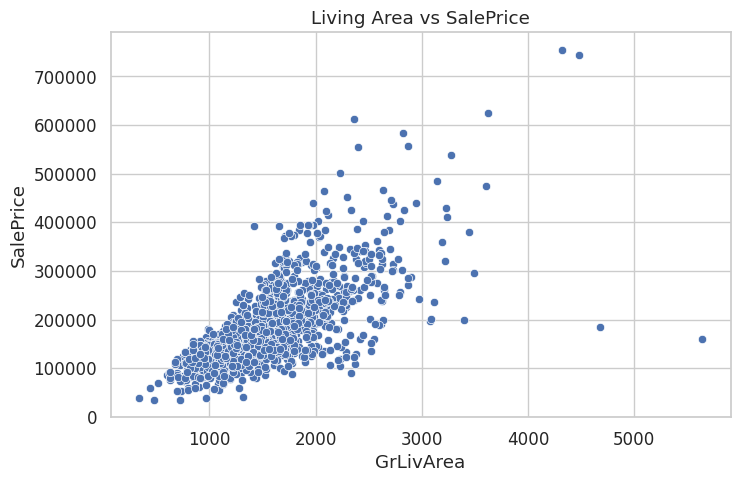

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train, x="GrLivArea", y="SalePrice")
plt.title("Living Area vs SalePrice")
plt.show()


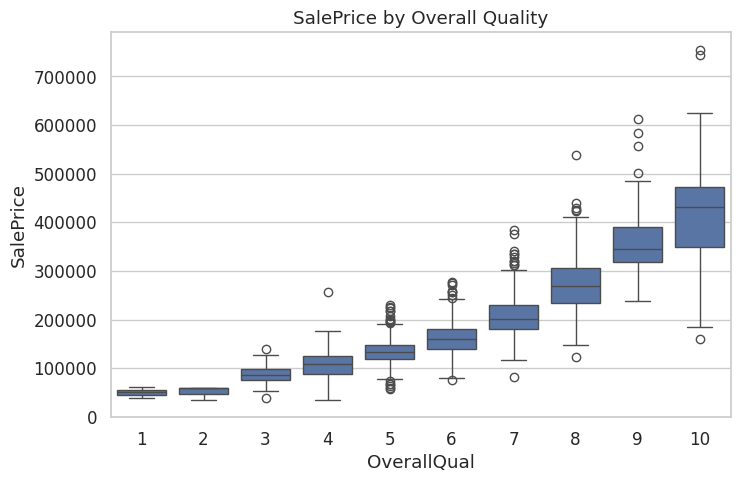

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train, x="OverallQual", y="SalePrice")
plt.title("SalePrice by Overall Quality")
plt.show()


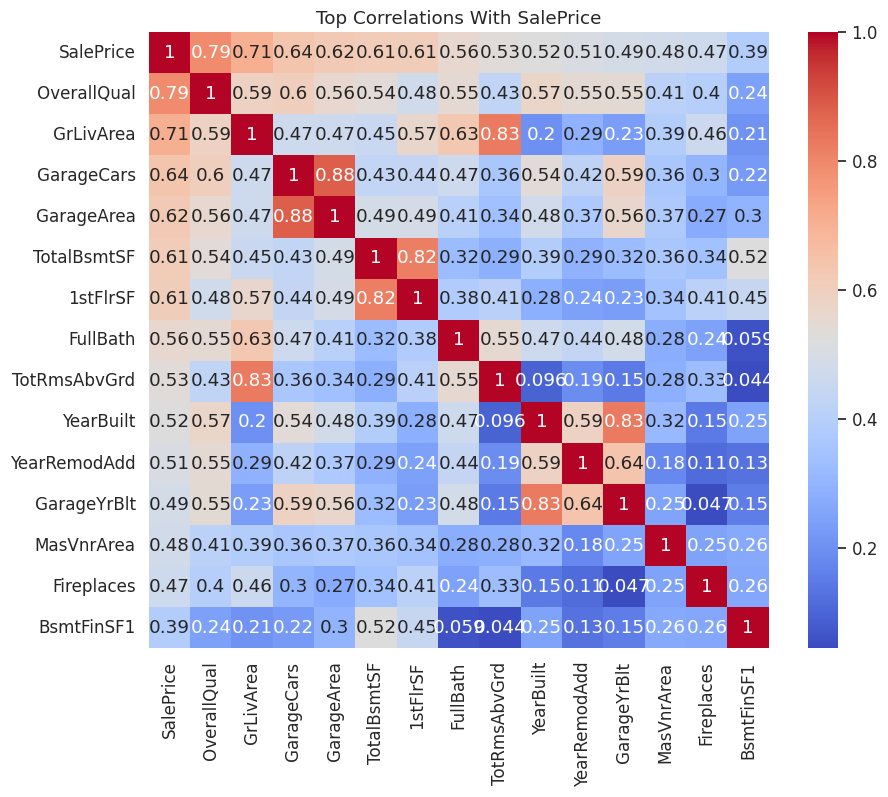

In [17]:
#corelation_15_feat
corr = train.corr(numeric_only=True)
top_corr = corr.nlargest(15, "SalePrice").index

plt.figure(figsize=(10, 8))
sns.heatmap(train[top_corr].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlations With SalePrice")
plt.show()


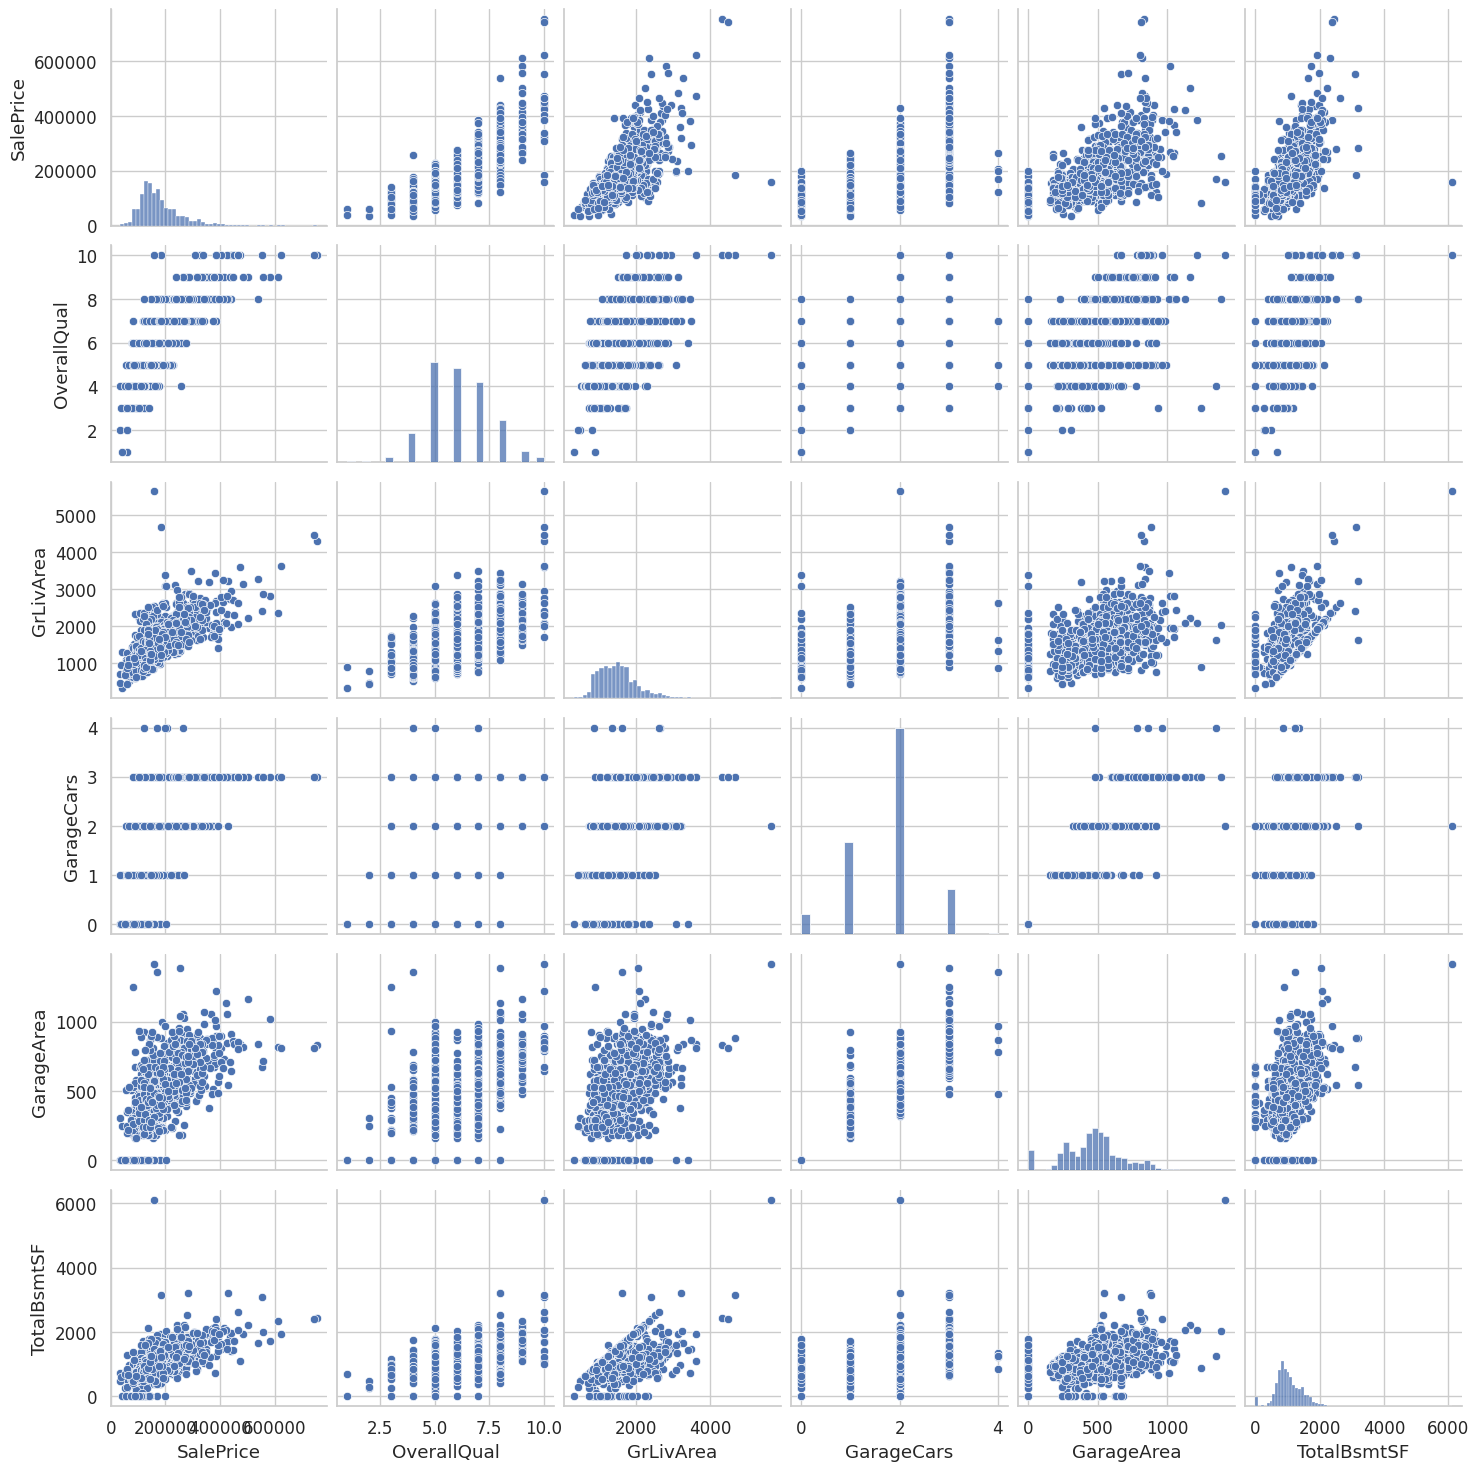

In [18]:
top_features = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF"]
sns.pairplot(train[top_features])
plt.show()


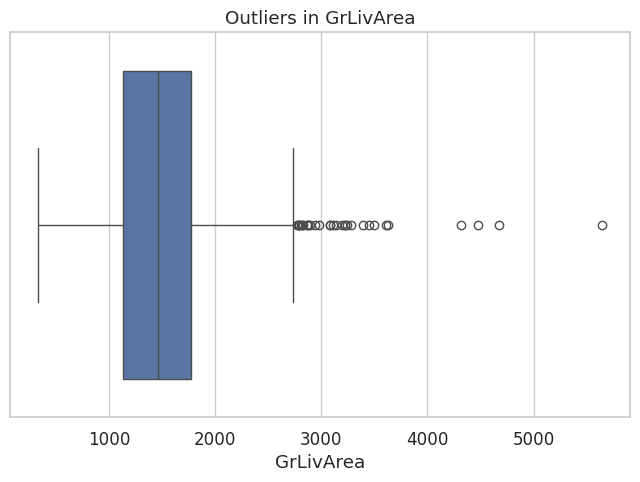

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=train["GrLivArea"])
plt.title("Outliers in GrLivArea")
plt.show()

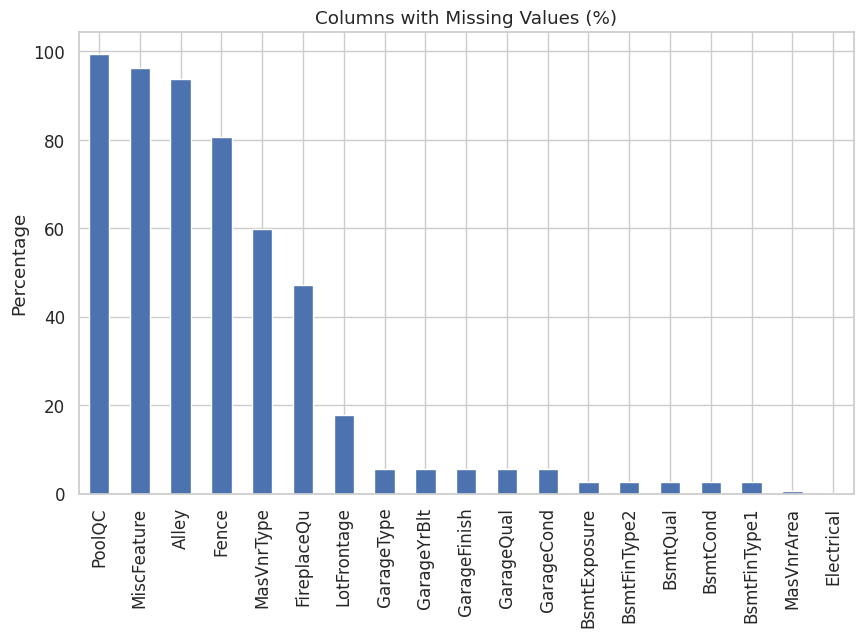

In [20]:
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
missing_percent.plot(kind="bar")
plt.title("Columns with Missing Values (%)")
plt.ylabel("Percentage")
plt.show()

In [21]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

print("Categorical Columns:", len(cat_cols))
print("Numerical Columns:", len(num_cols))


Categorical Columns: 43
Numerical Columns: 37


In [22]:
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}


In [25]:
results = {}
best_model = None
best_score = float("inf")

for name, model in models.items():

    print(f"\nTraining {name}...")

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)

    results[name] = mae
    print(f"{name} MAE: {mae:.2f}")

    if mae < best_score:
        best_score = mae
        best_model = pipe



Training Linear Regression...
Linear Regression MAE: 20485.66

Training Random Forest...
Random Forest MAE: 17494.26

Training XGBoost...
XGBoost MAE: 15494.72


In [26]:
print("\nModel Performance (Lower = Better MAE):")
for name, score in results.items():
    print(f"{name}: {score:.2f}")

print("\nBest Model:", min(results, key=results.get))
print("Best MAE:", best_score)



Model Performance (Lower = Better MAE):
Linear Regression: 20485.66
Random Forest: 17494.26
XGBoost: 15494.72

Best Model: XGBoost
Best MAE: 15494.71875


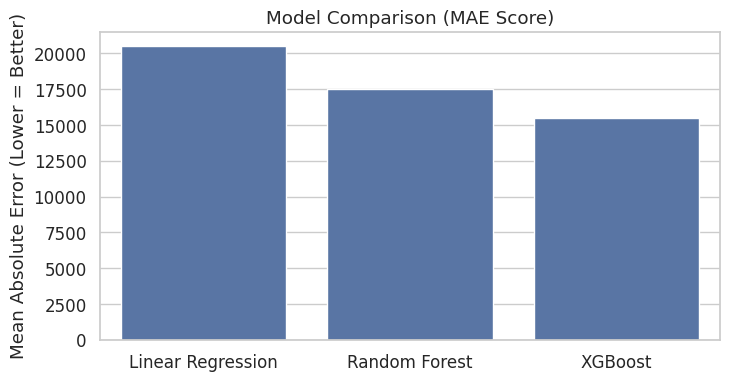

In [27]:
plt.figure(figsize=(8, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Comparison (MAE Score)")
plt.ylabel("Mean Absolute Error (Lower = Better)")
plt.show()

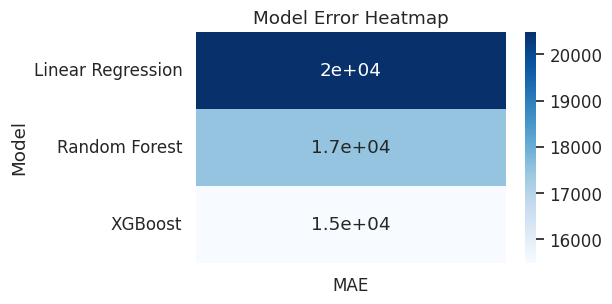

In [28]:
results_df = pd.DataFrame({
    "Model": list(results.keys()),
    "MAE": list(results.values())
})

plt.figure(figsize=(5, 3))
sns.heatmap(results_df[["MAE"]].set_index(results_df["Model"]), annot=True, cmap="Blues")
plt.title("Model Error Heatmap")
plt.show()

In [29]:
from sklearn.metrics import r2_score, mean_squared_error

metrics_results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)

    r2 = r2_score(y_valid, preds)
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)

    metrics_results.append([name, results[name], mse, rmse, r2])

metrics_df = pd.DataFrame(metrics_results,
                          columns=["Model", "MAE", "MSE", "RMSE", "R2 Score"])

metrics_df

,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,20485.659297,9.814308e+08,31327.795381,0.872048
1,Random Forest,17494.262637,8.111548e+08,28480.779436,0.894248
2,XGBoost,15494.718750,6.290280e+08,25080.429980,0.917992


/tmp/ipython-input-4052971977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2 Score", data=metrics_df, palette="viridis")


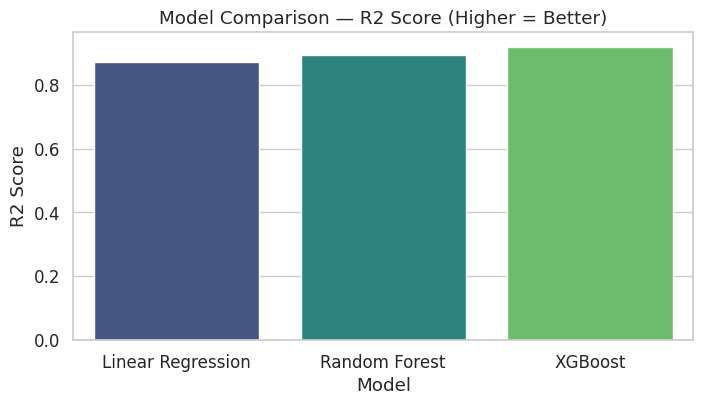

In [30]:
plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="R2 Score", data=metrics_df, palette="viridis")
plt.title("Model Comparison — R2 Score (Higher = Better)")
plt.ylabel("R2 Score")
plt.show()

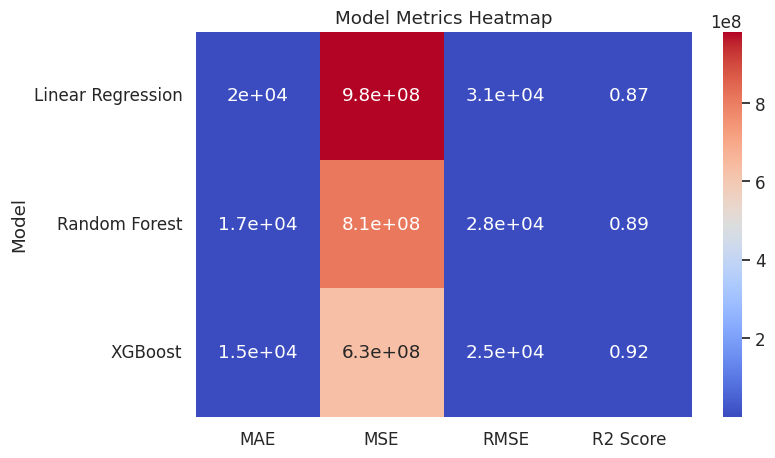

In [31]:
plt.figure(figsize=(8, 5))
sns.heatmap(metrics_df.set_index("Model"), annot=True, cmap="coolwarm")
plt.title("Model Metrics Heatmap")
plt.show()

In [32]:
best_model.fit(X, y)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [33]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Best Model Saved as model.pkl")


Best Model Saved as model.pkl


In [34]:
from google.colab import files
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
import numpy as np

def predict_price_fixed(sqft, quality, year_built, full_bath,
                        garage_cars, garage_area, lot_area, neighborhood):


    row = {
        "GrLivArea": sqft,
        "OverallQual": quality,
        "YearBuilt": year_built,
        "FullBath": full_bath,
        "GarageCars": garage_cars,
        "GarageArea": garage_area,
        "LotArea": lot_area,
        "Neighborhood": neighborhood,
    }


    df = pd.DataFrame([row])


    for col in X.columns:  # X is your training features DataFrame
        if col not in df.columns:
            if col in num_cols:
                df[col] = X[col].median()   # numeric default
            else:
                df[col] = X[col].mode()[0]  # categorical default


    df = df[X.columns]

    return best_model.predict(df)[0]

In [43]:
sqft = int(input("Enter square feet: "))
quality = int(input("Enter quality (1-10): "))
year_built = int(input("Enter year built: "))
full_bath = int(input("Enter number of full bathrooms: "))
garage_cars = int(input("Enter garage capacity (cars): "))
garage_area = int(input("Enter garage area (sq ft): "))
lot_area = int(input("Enter lot area (sq ft): "))
neighborhood = input("Enter neighborhood name: ")

predicted_price = predict_price_fixed(
    sqft, quality, year_built, full_bath,
    garage_cars, garage_area, lot_area, neighborhood
)

print("\nPredicted House Price =", predicted_price)

Enter square feet: 1100
Enter quality (1-10): 5
Enter year built: 1975
Enter number of full bathrooms: 1
Enter garage capacity (cars): 1
Enter garage area (sq ft): 250
Enter lot area (sq ft): 50000
Enter neighborhood name: mitchel

Predicted House Price = 140442.97


In [44]:
from google.colab import files
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>